In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# –û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º —á–∏—Å–ª–æ –ø–æ—Ç–æ–∫–æ–≤ BLAS (–≤–∞–∂–Ω–æ –¥–ª—è —Å—Ç–∞–±–∏–ª—å–Ω–æ–π –∑–∞–≥—Ä—É–∑–∫–∏)
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from GPTID.IntrinsicDim import PHD, prim_tree

In [3]:
model_path = 'Qwen/Qwen1.5-1.8B'
tokenizer_path = model_path

device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading the model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path).to(device)

In [4]:
MIN_SUBSAMPLE = 40
INTERMEDIATE_POINTS = 7

In [5]:
def preprocess_text(text):
    return text.replace('\n', ' ').replace('  ', ' ')

def decode_by_tokens(inputs):
    decoded_tokens = []
    for token in inputs['input_ids'].reshape(-1):
        decoded_tokens.append(tokenizer.decode([token]))

    return decoded_tokens


def get_embeds(text, model=None, tokenizer=None, returns_tokenized=False, max_length=2048):
    inputs = tokenizer(preprocess_text(text), truncation=True,
                       max_length=max_length, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outp = model(**inputs)

    if not returns_tokenized:
        return outp[0][0].cpu().numpy()

    return outp[0][0].cpu().numpy(), decode_by_tokens(inputs)

In [6]:
def get_phd_single(text, solver, max_length=2048):
    t0 = time.perf_counter()
    inputs = tokenizer(preprocess_text(text), truncation=True,
                       max_length=max_length, return_tensors="pt").to(device)
    t1 = time.perf_counter()
    tok_time = t1 - t0

    t0 = time.perf_counter()
    with torch.no_grad():
        outp = model(**inputs)
    t1 = time.perf_counter()
    emb_time = t1 - t0

    mx_points = inputs['input_ids'].shape[1]
    mn_points = MIN_SUBSAMPLE
    step = (mx_points - mn_points) // INTERMEDIATE_POINTS

    t0 = time.perf_counter()
    result = solver.fit_transform(
        outp[0][0].cpu().numpy(),
        min_points=mn_points,
        max_points=mx_points - step,
        point_jump=step
    )
    t1 = time.perf_counter()
    phd_time = t1 - t0

    return result, tok_time, emb_time, phd_time


In [7]:
import jsonlines

file_path = "../data/en_train.jsonl"

texts = []
with jsonlines.open(file_path, "r") as reader:
    for obj in reader:
        texts.append(obj)

print(f"–ó–∞–≥—Ä—É–∂–µ–Ω–æ –æ–±—ä–µ–∫—Ç–æ–≤: {len(texts)}")
print("–ü—Ä–∏–º–µ—Ä:", texts[4])

–ó–∞–≥—Ä—É–∂–µ–Ω–æ –æ–±—ä–µ–∫—Ç–æ–≤: 610767
–ü—Ä–∏–º–µ—Ä: {'id': 'cdf050ad-7d90-4235-b7c6-46ca6cfc4382', 'source': 'm4gt', 'sub_source': 'wikipedia', 'lang': 'en', 'model': 'human', 'label': 0, 'text': 'Malta participated in the Eurovision Song Contest 2005 with the song "Angel" written and performed by Chiara, who had previously represented Malta at the Eurovision Song Contest in the 1998 edition where he achieved ninth place with the song "The One That I Love". The Maltese entry for the 2005 contest in Kyiv, Ukraine was selected through the national final Malta Song for Europe 2005, organised by the Maltese broadcaster Public Broadcasting Services (PBS). The competition consisted of a final, held on 19 February 2005, where "Angel" performed by Chiara eventually emerged as the winning entry after gaining 19% of the public televote.\n\nAs one of the ten highest placed finishers in 2004, Malta automatically qualified to compete in the final of the Eurovision Song Contest. Performing dur

–ü–æ—Å–º–æ—Ç—Ä–∏–º —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–∏ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–∏ –∏ –ø–æ–¥—Å—á–µ—Ç–∞ —Å–∞–º–æ–≥–æ PHD. –î–∞–ª–µ–µ –≤–µ–∑–¥–µ —Å–º–æ—Ç—Ä–∏–º get_phd_single, –µ—Å–ª–∏ –Ω–µ –æ–≥–æ–≤–æ—Ä–µ–Ω–æ –¥—Ä—É–≥–æ–µ.

In [8]:
import gc

token_lengths = [128, 256, 512, 1024, 2048, 4096]

# –î–ª–∏–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç (>5000 —Ç–æ–∫–µ–Ω–æ–≤)
idx = 274400
text = texts[idx]['text']

results = []

for length in token_lengths:
    solver = PHD(metric="euclidean", alpha=1.0, n_points=9)
    phd_val, tok_time, emb_time, phd_time = get_phd_single(text, solver, max_length=length)
    gc.collect()
    torch.cuda.empty_cache()
    results.append({
        "tokens": length,
        "phd": phd_val,
        "time_tokenize": tok_time,
        "time_embed": emb_time,
        "time_phd": phd_time,
        "time_total": tok_time + emb_time + phd_time
    })

df = pd.DataFrame(results)
df.to_csv("phd_timings_split.csv", index=False)



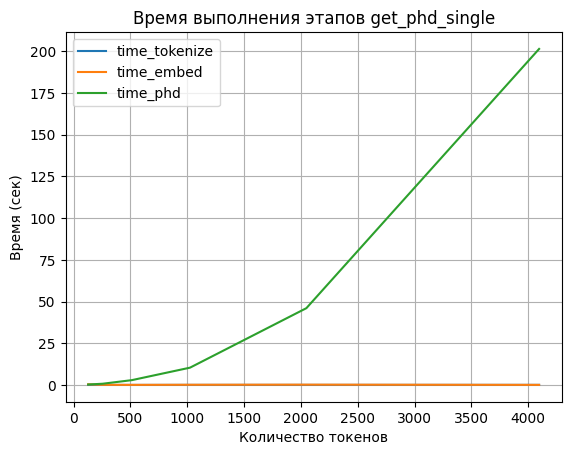

In [9]:
for col in ["time_tokenize", "time_embed", "time_phd"]:
    plt.plot(df["tokens"], df[col], label=col)

plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤")
plt.ylabel("–í—Ä–µ–º—è (—Å–µ–∫)")
plt.title("–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —ç—Ç–∞–ø–æ–≤ get_phd_single")
plt.legend()
plt.grid()
plt.show()

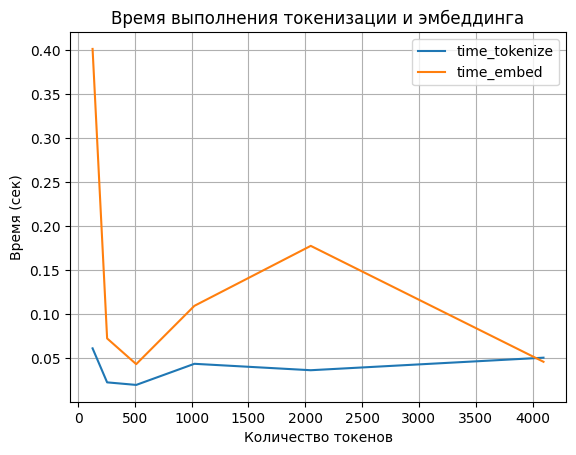

In [10]:
for col in ["time_tokenize", "time_embed"]:
    plt.plot(df["tokens"], df[col], label=col)

plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤")
plt.ylabel("–í—Ä–µ–º—è (—Å–µ–∫)")
plt.title("–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏ –∏ —ç–º–±–µ–¥–¥–∏–Ω–≥–∞")
plt.legend()
plt.grid()
plt.show()

## –í—Ä–µ–º—è —Ñ—É–Ω–∫—Ü–∏–π –≤ GPTID.IntrinsicDim

In [11]:
from scipy.spatial.distance import cdist
from threading import Thread

class TimedPHD(PHD):
    def fit_transform(self, X, y=None, min_points=50, max_points=512, point_jump=40, dist=False):
        self.timings = {"threads_total": 0.0, "cdist": 0.0, "prim_tree": 0.0, "regression": 0.0}

        self.distance_matrix = dist
        ms = np.zeros(self.n_reruns)
        test_n = range(min_points, max_points, point_jump)
        threads = []

        def timed_calc(thread_id):
            lengths = []
            for n in test_n:
                restarts = self.n_points_min if X.shape[0] <= 2 * n else self.n_points
                reruns = np.ones(restarts)
                for i in range(restarts):
                    sample = self._sample_W(X, n)

                    if self.distance_matrix:
                        t0 = time.perf_counter()
                        reruns[i] = prim_tree(sample, self.alpha)
                        self.timings["prim_tree"] += time.perf_counter() - t0
                    else:
                        t0 = time.perf_counter()
                        D = cdist(sample, sample, metric=self.metric)
                        self.timings["cdist"] += time.perf_counter() - t0

                        t0 = time.perf_counter()
                        reruns[i] = prim_tree(D, self.alpha)
                        self.timings["prim_tree"] += time.perf_counter() - t0

                lengths.append(np.median(reruns))

            x = np.log(np.array(list(test_n)))
            y = np.log(lengths)
            N = len(x)

            t0 = time.perf_counter()
            slope = (N * (x * y).sum() - x.sum() * y.sum()) / (N * (x ** 2).sum() - x.sum() ** 2)
            self.timings["regression"] += time.perf_counter() - t0
            ms[thread_id] = slope

        t0 = time.perf_counter()
        for i in range(self.n_reruns):
            thread = Thread(target=timed_calc, args=(i,))
            threads.append(thread)
            thread.start()

        for thread in threads:
            thread.join()
        self.timings["threads_total"] = time.perf_counter() - t0

        m = ms.mean()
        return 1 / (1 - m), self.timings


In [12]:
import gc

idx = 274400
text = texts[idx]['text']
token_counts = [128, 256, 512, 1024, 2048]

results = []

for n in token_counts:
    print(f"\nüîç –¢–æ–∫–µ–Ω–æ–≤: {n}")
    gc.collect()
    torch.cuda.empty_cache()
    X = get_embeds(text, model=model, tokenizer=tokenizer, max_length=n)
    
    solver = TimedPHD(alpha=1.0, metric="euclidean", n_points=9, n_reruns=3)
    phd_val, timings = solver.fit_transform(X, min_points=40, max_points=X.shape[0]-1, point_jump=40)

    results.append({
        "tokens": X.shape[0],
        "phd": phd_val,
        **timings
    })

df = pd.DataFrame(results)
df.to_csv("phd_runtime_real_embeds.csv", index=False)


üîç –¢–æ–∫–µ–Ω–æ–≤: 128

üîç –¢–æ–∫–µ–Ω–æ–≤: 256

üîç –¢–æ–∫–µ–Ω–æ–≤: 512

üîç –¢–æ–∫–µ–Ω–æ–≤: 1024

üîç –¢–æ–∫–µ–Ω–æ–≤: 2048


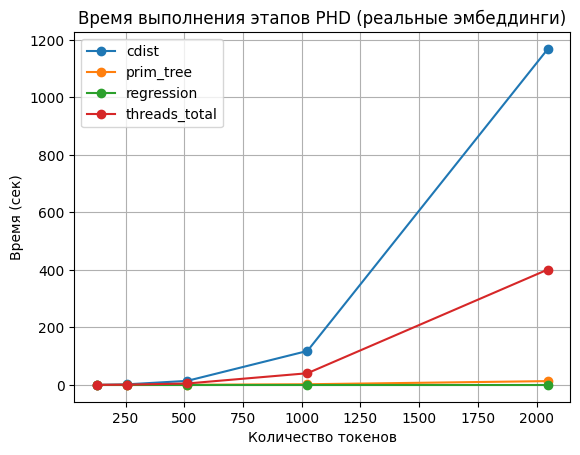

In [13]:
for col in ["cdist", "prim_tree", "regression", "threads_total"]:
    plt.plot(df["tokens"], df[col], label=col, marker="o")

plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤")
plt.ylabel("–í—Ä–µ–º—è (—Å–µ–∫)")
plt.title("–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —ç—Ç–∞–ø–æ–≤ PHD (—Ä–µ–∞–ª—å–Ω—ã–µ —ç–º–±–µ–¥–¥–∏–Ω–≥–∏)")
plt.legend()
plt.grid(True)
plt.show()

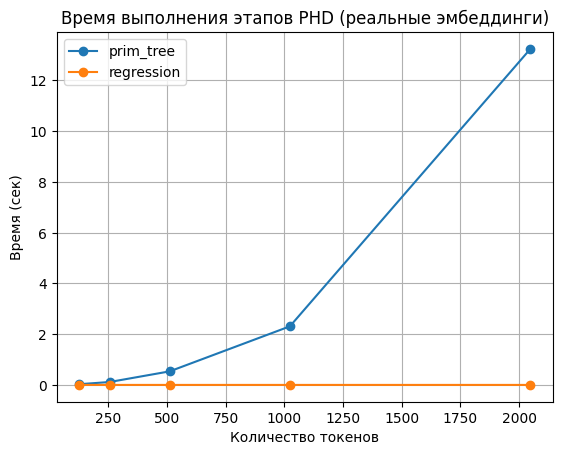

In [14]:
for col in ["prim_tree", "regression"]:
    plt.plot(df["tokens"], df[col], label=col, marker="o")

plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤")
plt.ylabel("–í—Ä–µ–º—è (—Å–µ–∫)")
plt.title("–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —ç—Ç–∞–ø–æ–≤ PHD (—Ä–µ–∞–ª—å–Ω—ã–µ —ç–º–±–µ–¥–¥–∏–Ω–≥–∏)")
plt.legend()
plt.grid(True)
plt.show()

## –ü–µ—Ä–µ–Ω–æ—Å `cdist` –Ω–∞ CUDA

–ü–æ–ø—Ä–æ–±–æ—É–µ–º –≤–æ—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —ç—Ç–∏–º https://stackoverflow.com/questions/46655878/how-to-calculate-pairwise-distance-matrix-on-the-gpu

In [15]:
from GPTID.IntrinsicDim import PHD as PHD_CPU
from GPTID.IntrinsicDimCUDA import PHD as PHD_GPU

In [16]:
token_lengths = [128, 256, 512, 1024, 2048, 4096]

idx = 274400
text = texts[idx]['text']

results = []

for length in token_lengths:
    print(f"\nüîç Tokens: {length}")
    
    # –ü–æ–ª—É—á–∞–µ–º —ç–º–±–µ–¥–¥–∏–Ω–≥–∏ + –≤—Ä–µ–º—è
    phd_score_cpu, tok_time, emb_time, phd_time_cpu = get_phd_single(text, PHD_CPU(n_reruns=3), max_length=length)
    phd_score_gpu, _, _, phd_time_gpu = get_phd_single(text, PHD_GPU(n_reruns=3), max_length=length)

    results.append({
        "tokens": length,
        "phd_cpu": phd_score_cpu,
        "phd_gpu": phd_score_gpu,
        "phd_time_cpu": phd_time_cpu,
        "phd_time_gpu": phd_time_gpu,
    })


üîç Tokens: 128


/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 36 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: Nu


üîç Tokens: 256


/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 81 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 121 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))



üîç Tokens: 512

üîç Tokens: 1024

üîç Tokens: 2048

üîç Tokens: 4096


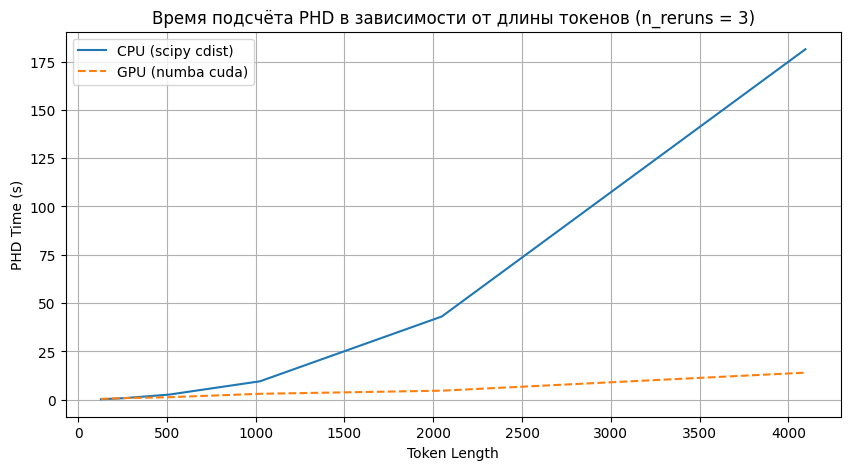

In [17]:
df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
plt.plot(df["tokens"], df["phd_time_cpu"], label="CPU (scipy cdist)")
plt.plot(df["tokens"], df["phd_time_gpu"], label="GPU (numba cuda)", linestyle="--")
plt.xlabel("Token Length")
plt.ylabel("PHD Time (s)")
plt.title("–í—Ä–µ–º—è –ø–æ–¥—Å—á—ë—Ç–∞ PHD –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –¥–ª–∏–Ω—ã —Ç–æ–∫–µ–Ω–æ–≤ (n_reruns = 3)")
plt.legend()
plt.grid(True)
plt.show()

## –ó–∞–º–µ—Ä –≤—Ä–µ–º–µ–Ω–∏ `get_phd_single_loop`

In [4]:
from phd_qwen import get_phd_single_loop
from GPTID.IntrinsicDimCUDA import PHD as PHD_GPU

solver = PHD_GPU()

idx = 274400
text = texts[idx]['text']

start = time.perf_counter()
phd_mean = get_phd_single_loop(text, solver=solver, n_tries=10, max_length=1024)
end = time.perf_counter()

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


/home/pedashenkovl/PHD/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)


In [5]:
print(f"–°—Ä–µ–¥–Ω–µ–µ PHD: {phd_mean:.4f}")
print(f"–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è 10 –ø—Ä–æ–≥–æ–Ω–æ–≤: {end - start:.2f} —Å–µ–∫")

–°—Ä–µ–¥–Ω–µ–µ PHD: 4.8295
–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è 10 –ø—Ä–æ–≥–æ–Ω–æ–≤: 26.73 —Å–µ–∫


In [6]:
all_phd = []
all_times = []

for i in range(15):
    solver = PHD_GPU(n_reruns=3, n_points=7, n_points_min=3)
    
    start = time.perf_counter()
    phd_mean = get_phd_single_loop(text, solver=solver, n_tries=10, max_length=1024)
    end = time.perf_counter()

    duration = end - start
    all_phd.append(phd_mean)
    all_times.append(duration)

    print(f"[{i+1}/15] –°—Ä–µ–¥–Ω–µ–µ PHD: {phd_mean:.4f} | –í—Ä–µ–º—è: {duration:.2f} —Å–µ–∫")

print(f"\n–°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –∑–∞ –æ–¥–∏–Ω –ø—Ä–æ–≥–æ–Ω get_phd_single_loop: {sum(all_times) / len(all_times):.2f} —Å–µ–∫")

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
[1/15] –°—Ä–µ–¥–Ω–µ–µ PHD: 4.9456 | –í—Ä–µ–º—è: 26.17 —Å–µ–∫
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points =

In [8]:
from GPTID.IntrinsicDim import PHD as PHD_CPU
all_phd_CPU = []
all_times_CPU = []

for i in range(1):
    solver = PHD_CPU(n_reruns=3, n_points=7, n_points_min=3)
    
    start = time.perf_counter()
    phd_mean = get_phd_single_loop(text, solver=solver, n_tries=10, max_length=1024)
    end = time.perf_counter()

    duration = end - start
    all_phd_CPU.append(phd_mean)
    all_times_CPU.append(duration)

    print(f"[{i+1}/15] –°—Ä–µ–¥–Ω–µ–µ PHD: {phd_mean:.4f} | –í—Ä–µ–º—è: {duration:.2f} —Å–µ–∫")

print(f"\n–°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –∑–∞ –æ–¥–∏–Ω –ø—Ä–æ–≥–æ–Ω get_phd_single_loop: {sum(all_times_CPU) / len(all_times_CPU):.2f} —Å–µ–∫")

mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
mn_points = 40 max_points = 1024 point_jump = 140
input_shape: (1024, 2048)
[1/15] –°—Ä–µ–¥–Ω–µ–µ PHD: 9.2770 | –í—Ä–µ–º—è: 96.65 —Å–µ–∫

–°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –∑–∞ –æ–¥–∏–Ω –ø—Ä–æ–≥–æ–Ω get_phd_single_loop: 96.65 —Å–µ–∫


## –í—Ä–µ–º—è —Ñ—É–Ω–∫—Ü–∏–π –≤ GPTID.IntrinsicDimCUDA

In [18]:
from GPTID.IntrinsicDimCUDA import PHD as PHD_CUDA
from GPTID.IntrinsicDimCUDA import gpu_dist_matrix, prim_tree
import time
import numpy as np
from threading import Thread

class TimedPHD_CUDA(PHD_CUDA):
    def fit_transform(self, X, y=None, min_points=50, max_points=512, point_jump=40, dist=False):
        self.timings = {
            "threads_total": 0.0,
            "gpu_dist": 0.0,
            "prim_tree": 0.0,
            "regression": 0.0
        }

        self.distance_matrix = dist
        ms = np.zeros(self.n_reruns)
        test_n = range(min_points, max_points, point_jump)
        threads = []

        def timed_calc(thread_id):
            lengths = []
            for n in test_n:
                restarts = self.n_points_min if X.shape[0] <= 2 * n else self.n_points
                reruns = np.ones(restarts)

                for i in range(restarts):
                    sample = self._sample_W(X, n)

                    if self.distance_matrix:
                        t0 = time.perf_counter()
                        reruns[i] = prim_tree(sample, self.alpha)
                        self.timings["prim_tree"] += time.perf_counter() - t0
                    else:
                        t0 = time.perf_counter()
                        D = gpu_dist_matrix(sample)
                        self.timings["gpu_dist"] += time.perf_counter() - t0

                        t0 = time.perf_counter()
                        reruns[i] = prim_tree(D, self.alpha)
                        self.timings["prim_tree"] += time.perf_counter() - t0

                lengths.append(np.median(reruns))

            x = np.log(np.array(list(test_n)))
            y = np.log(lengths)
            N = len(x)

            t0 = time.perf_counter()
            slope = (N * (x * y).sum() - x.sum() * y.sum()) / (N * (x ** 2).sum() - x.sum() ** 2)
            self.timings["regression"] += time.perf_counter() - t0
            ms[thread_id] = slope

        t0 = time.perf_counter()
        for i in range(self.n_reruns):
            thread = Thread(target=timed_calc, args=(i,))
            threads.append(thread)
            thread.start()
        for thread in threads:
            thread.join()
        self.timings["threads_total"] = time.perf_counter() - t0

        m = ms.mean()
        return 1 / (1 - m), self.timings


In [19]:
import gc
import pandas as pd
import matplotlib.pyplot as plt

idx = 274400
text = texts[idx]['text']
token_counts = [128, 256, 512, 1024, 2048]

results = []

for n in token_counts:
    print(f"\n –¢–æ–∫–µ–Ω–æ–≤: {n}")
    gc.collect()
    torch.cuda.empty_cache()

    X = get_embeds(text, model=model, tokenizer=tokenizer, max_length=n)

    solver = TimedPHD_CUDA(alpha=1.0, metric="euclidean", n_reruns=3)
    phd_val, timings = solver.fit_transform(X, min_points=40, max_points=X.shape[0]-1, point_jump=40)

    results.append({
        "tokens": X.shape[0],
        "phd": phd_val,
        **timings
    })

df = pd.DataFrame(results)
df.to_csv("phd_runtime_real_embeds_cuda.csv", index=False)



 –¢–æ–∫–µ–Ω–æ–≤: 128

 –¢–æ–∫–µ–Ω–æ–≤: 256

 –¢–æ–∫–µ–Ω–æ–≤: 512

 –¢–æ–∫–µ–Ω–æ–≤: 1024

 –¢–æ–∫–µ–Ω–æ–≤: 2048


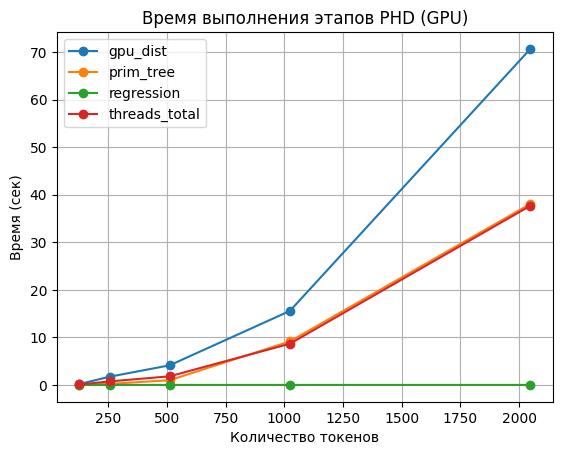

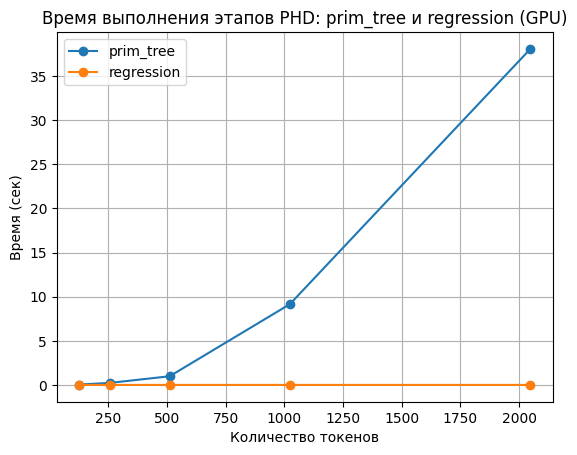

In [20]:
for col in ["gpu_dist", "prim_tree", "regression", "threads_total"]:
    plt.plot(df["tokens"], df[col], label=col, marker="o")

plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤")
plt.ylabel("–í—Ä–µ–º—è (—Å–µ–∫)")
plt.title("–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —ç—Ç–∞–ø–æ–≤ PHD (GPU)")
plt.legend()
plt.grid(True)
plt.show()

# –ë–æ–ª–µ–µ —á–∏—Å—Ç—ã–π –≥—Ä–∞—Ñ–∏–∫
for col in ["prim_tree", "regression"]:
    plt.plot(df["tokens"], df[col], label=col, marker="o")

plt.xlabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–æ–∫–µ–Ω–æ–≤")
plt.ylabel("–í—Ä–µ–º—è (—Å–µ–∫)")
plt.title("–í—Ä–µ–º—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è —ç—Ç–∞–ø–æ–≤ PHD: prim_tree –∏ regression (GPU)")
plt.legend()
plt.grid(True)
plt.show()
